In [7]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.metrics import Metric
from tensorflow.keras import backend as K

# Custom MacroF1Score Metric
class MacroF1Score(Metric):
    def __init__(self, num_classes, name='macro_f1_score', **kwargs):
        super(MacroF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert y_true to one-hot if not already
        y_true = tf.cast(y_true, tf.float32)
        if len(y_true.shape) == 1 or y_true.shape[-1] == 1:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)
        else:
            y_true = tf.cast(y_true, tf.float32)

        # Get predicted class indices
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.one_hot(y_pred, depth=self.num_classes)

        # Compute TP, FP, FN for each class
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

        # Update state
        self.true_positives.assign(self.true_positives + tp)
        self.false_positives.assign(self.false_positives + fp)
        self.false_negatives.assign(self.false_negatives + fn)

    def result(self):
        precision = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_positives)
        recall = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_negatives)
        
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        macro_f1 = tf.reduce_mean(f1)
        return macro_f1

    def reset_states(self):
        self.true_positives.assign(tf.zeros(self.num_classes))
        self.false_positives.assign(tf.zeros(self.num_classes))
        self.false_negatives.assign(tf.zeros(self.num_classes))

# GPU Setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("✅ Using GPU")
else:
    print("⚠ Using CPU")

# Data Paths
base_path = "/kaggle/working/output"
os.makedirs(base_path, exist_ok=True)
train_dir = "/kaggle/input/split-data/content/split_data/train"
test_dir = "/kaggle/input/split-data/content/split_data/test"

# Define the mapping for 5-class classification
human_mapping = {
    'California_Wildfires': 2,      # "Infrastructure and utility damage"
    'Hurricane_Harvey': 1,         # "Rescue volunteering or donation effort"
    'mexico_earthquake': 4,        # "Not-humanitarian"
    'iraq_iran_earthquake': 0,     # "Affected individuals"
    'srilanka_floods': 3,          # "Other relevant information"
    'Hurricane_Maria': 1,          # "Rescue volunteering or donation effort"
    'Hurricane_Irma': 1            # "Rescue volunteering or donation effort"
}

# Utility function: Create DataFrame
def create_dataframe(data_dir, mapping):
    filepaths = []
    labels = []

    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory {data_dir} does not exist.")

    for class_name, label in mapping.items():
        folder_path = os.path.join(data_dir, class_name)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist. Skipping...")
            continue

        files = glob.glob(os.path.join(folder_path, '*.jpg')) + \
                glob.glob(os.path.join(folder_path, '*.jpeg')) + \
                glob.glob(os.path.join(folder_path, '*.png'))

        if not files:
            print(f"Warning: No image files found in {folder_path}. Skipping...")
            continue

        print(f"Found {len(files)} files in {folder_path}")
        filepaths.extend(files)
        labels.extend([str(label)] * len(files))

    df = pd.DataFrame({'filename': filepaths, 'class': labels})
    if df.empty:
        raise ValueError(f"No data found in {data_dir}.")
    return df

# Create DataFrames
try:
    train_df = create_dataframe(train_dir, human_mapping)
    test_df = create_dataframe(test_dir, human_mapping)
except Exception as e:
    print(f"Error creating DataFrames: {e}")
    raise

# Data Augmentation for Imbalanced Classes
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    fill_mode='nearest'
)

# Identify and augment minority classes
class_counts = train_df['class'].value_counts()
minority_threshold = class_counts.median() * 0.7
augmentation_factor = 3

for minority_class in class_counts[class_counts < minority_threshold].index:
    minority_class_dir = os.path.join(base_path, f"augmented_class_{minority_class}")
    os.makedirs(minority_class_dir, exist_ok=True)

    augmented_filepaths = []
    augmented_labels = []
    for img_file in train_df[train_df['class'] == minority_class]['filename']:
        img = load_img(img_file)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        save_prefix = "aug_" + os.path.splitext(os.path.basename(img_file))[0]
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=minority_class_dir, save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i >= augmentation_factor:
                break
    new_files = glob.glob(os.path.join(minority_class_dir, '*.jpg'))
    augmented_filepaths.extend(new_files)
    augmented_labels.extend([minority_class] * len(new_files))
    
    augmented_df = pd.DataFrame({'filename': augmented_filepaths, 'class': augmented_labels})
    train_df = pd.concat([train_df, augmented_df], ignore_index=True)
    print(f"Augmentation complete for class {minority_class}! Added {len(augmented_filepaths)} images.")

# Data Generators
IMG_SIZE = (224, 224)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=[0.8, 1.2],
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

try:
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
except Exception as e:
    print(f"Error setting up data generators: {e}")
    raise

# Compute Class Weights
try:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['class']),
        y=train_df['class']
    )
    class_weights = {i: w for i, w in enumerate(class_weights)}
    print("Computed class weights:", class_weights)
except Exception as e:
    print(f"Error computing class weights: {e}")
    raise

# Build VGG16-based model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = True

# Freeze all layers except last 6
for layer in base_model.layers[:-6]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', MacroF1Score(num_classes=5)]
)

# Callbacks
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_ckpt_best = ModelCheckpoint(
    os.path.join(base_path, "best_model.keras"),
    save_best_only=True,
    monitor='accuracy',
    mode='max'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop, model_ckpt_best],
    verbose=1
)

# Save Final Model
final_model_path = os.path.join(base_path, "final_trained_model.keras")
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(os.path.join(base_path, "model_flutter.tflite"), "wb") as f:
    f.write(tflite_model)
print("✅ TFLite model saved")

# Evaluation on Test Set
model = load_model(os.path.join(base_path, "best_model.keras"), custom_objects={'MacroF1Score': MacroF1Score})
y_true_test = test_generator.classes
y_pred_test = model.predict(test_generator)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

cm = confusion_matrix(y_true_test, y_pred_test_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
    "Affected individuals",
    "Rescue volunteering or donation effort",
    "Infrastructure and utility damage",
    "Other relevant information",
    "Not-humanitarian"
], yticklabels=[
    "Affected individuals",
    "Rescue volunteering or donation effort",
    "Infrastructure and utility damage",
    "Other relevant information",
    "Not-humanitarian"
])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig(os.path.join(base_path, 'confusion_matrix.png'))

test_acc = accuracy_score(y_true_test, y_pred_test_classes)
test_prec = precision_score(y_true_test, y_pred_test_classes, average='weighted')
test_rec = recall_score(y_true_test, y_pred_test_classes, average='weighted')
test_f1 = f1_score(y_true_test, y_pred_test_classes, average='weighted')

print("\n✅ Test Set Evaluation:")
print(f"Accuracy: {test_acc:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f} | F1 Score: {test_f1:.4f}")
print("\n🧾 Classification Report (Test):")
print(classification_report(y_true_test, y_pred_test_classes, target_names=[
    "Affected individuals",
    "Rescue volunteering or donation effort",
    "Infrastructure and utility damage",
    "Other relevant information",
    "Not-humanitarian"
]))

# Visualize Metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(base_path, 'training_metrics.png'))

✅ Using GPU
Found 1235 files in /kaggle/input/split-data/content/split_data/train/California_Wildfires
Found 3386 files in /kaggle/input/split-data/content/split_data/train/Hurricane_Harvey
Found 1024 files in /kaggle/input/split-data/content/split_data/train/mexico_earthquake
Found 435 files in /kaggle/input/split-data/content/split_data/train/iraq_iran_earthquake
Found 742 files in /kaggle/input/split-data/content/split_data/train/srilanka_floods
Found 3447 files in /kaggle/input/split-data/content/split_data/train/Hurricane_Maria
Found 3446 files in /kaggle/input/split-data/content/split_data/train/Hurricane_Irma
Found 309 files in /kaggle/input/split-data/content/split_data/test/California_Wildfires
Found 847 files in /kaggle/input/split-data/content/split_data/test/Hurricane_Harvey
Found 256 files in /kaggle/input/split-data/content/split_data/test/mexico_earthquake
Found 108 files in /kaggle/input/split-data/content/split_data/test/iraq_iran_earthquake
Found 186 files in /kaggle/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746999649.363084      92 service.cc:148] XLA service 0x78f204004f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746999649.363972      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746999649.827195      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/551 ━━━━━━━━━━━━━━━━━━━━ 2:50:06 19s/step - accuracy: 0.1562 - loss: 1.8881 - macro_f1_score: 0.0771

I0000 00:00:1746999660.946244      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


551/551 ━━━━━━━━━━━━━━━━━━━━ 271s 459ms/step - accuracy: 0.2285 - loss: 1.6006 - macro_f1_score: 0.1903
Epoch 2/15
551/551 ━━━━━━━━━━━━━━━━━━━━ 218s 390ms/step - accuracy: 0.3419 - loss: 1.4373 - macro_f1_score: 0.2835
Epoch 3/15
551/551 ━━━━━━━━━━━━━━━━━━━━ 217s 389ms/step - accuracy: 0.4140 - loss: 1.2899 - macro_f1_score: 0.3518
Epoch 4/15
551/551 ━━━━━━━━━━━━━━━━━━━━ 216s 388ms/step - accuracy: 0.4546 - loss: 1.1828 - macro_f1_score: 0.3987
Epoch 5/15
551/551 ━━━━━━━━━━━━━━━━━━━━ 216s 386ms/step - accuracy: 0.4869 - loss: 1.1306 - macro_f1_score: 0.4188
Epoch 6/15
551/551 ━━━━━━━━━━━━━━━━━━━━ 219s 392ms/step - accuracy: 0.4866 - loss: 1.0916 - macro_f1_score: 0.4277
Epoch 7/15
551/551 ━━━━━━━━━━━━━━━━━━━━ 218s 391ms/step - accuracy: 0.5117 - loss: 1.0473 - macro_f1_score: 0.4399
Epoch 8/15
551/551 ━━━━━━━━━━━━━━━━━━━━ 220s 393ms/step - accuracy: 0.5070 - loss: 1.0194 - macro_f1_score: 0.4418
Epoch 9/15
551/551 ━━━━━━━━━━━━━━━━━━━━ 219s 392ms/step - accuracy: 0.5418 - loss: 0.9592 -

W0000 00:00:1747002956.646621      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747002956.646670      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1747002956.661847      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


✅ TFLite model saved


TypeError: <class '__main__.MacroF1Score'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'MacroF1Score', 'config': {'name': 'macro_f1_score', 'dtype': 'float32'}, 'registered_name': 'MacroF1Score'}.

Exception encountered: MacroF1Score.__init__() missing 1 required positional argument: 'num_classes'

✅ Using GPU
Found 1235 files in /kaggle/input/split-data/content/split_data/train/California_Wildfires
Found 3386 files in /kaggle/input/split-data/content/split_data/train/Hurricane_Harvey
Found 1024 files in /kaggle/input/split-data/content/split_data/train/mexico_earthquake
Found 435 files in /kaggle/input/split-data/content/split_data/train/iraq_iran_earthquake
Found 742 files in /kaggle/input/split-data/content/split_data/train/srilanka_floods
Found 3447 files in /kaggle/input/split-data/content/split_data/train/Hurricane_Maria
Found 3446 files in /kaggle/input/split-data/content/split_data/train/Hurricane_Irma
Found 309 files in /kaggle/input/split-data/content/split_data/test/California_Wildfires
Found 847 files in /kaggle/input/split-data/content/split_data/test/Hurricane_Harvey
Found 256 files in /kaggle/input/split-data/content/split_data/test/mexico_earthquake
Found 108 files in /kaggle/input/split-data/content/split_data/test/iraq_iran_earthquake
Found 186 files in /kaggle/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


592/592 ━━━━━━━━━━━━━━━━━━━━ 243s 398ms/step - accuracy: 0.2206 - loss: 1.5965 - macro_f1_score: 0.1686
Epoch 2/15
592/592 ━━━━━━━━━━━━━━━━━━━━ 231s 386ms/step - accuracy: 0.2828 - loss: 1.5302 - macro_f1_score: 0.2288
Epoch 3/15
592/592 ━━━━━━━━━━━━━━━━━━━━ 230s 384ms/step - accuracy: 0.3598 - loss: 1.4061 - macro_f1_score: 0.2972
Epoch 4/15
592/592 ━━━━━━━━━━━━━━━━━━━━ 230s 383ms/step - accuracy: 0.4418 - loss: 1.2705 - macro_f1_score: 0.3624
Epoch 5/15
592/592 ━━━━━━━━━━━━━━━━━━━━ 230s 384ms/step - accuracy: 0.4586 - loss: 1.1956 - macro_f1_score: 0.3833
Epoch 6/15
592/592 ━━━━━━━━━━━━━━━━━━━━ 229s 382ms/step - accuracy: 0.4842 - loss: 1.1565 - macro_f1_score: 0.4034
Epoch 7/15
592/592 ━━━━━━━━━━━━━━━━━━━━ 230s 384ms/step - accuracy: 0.5137 - loss: 1.0958 - macro_f1_score: 0.4275
Epoch 8/15
592/592 ━━━━━━━━━━━━━━━━━━━━ 231s 386ms/step - accuracy: 0.5321 - loss: 1.0539 - macro_f1_score: 0.4391
Epoch 9/15
592/592 ━━━━━━━━━━━━━━━━━━━━ 231s 386ms/step - accuracy: 0.5567 - loss: 1.0006 -

W0000 00:00:1747007075.140100      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747007075.140145      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


✅ TFLite model saved


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 229ms/step

✅ Test Set Evaluation:
Accuracy: 0.4984 | Precision: 0.7334 | Recall: 0.4984 | F1 Score: 0.5642

🧾 Classification Report (Test):
                                        precision    recall  f1-score   support

                  Affected individuals       0.30      0.10      0.15       108
Rescue volunteering or donation effort       0.87      0.50      0.64      2570
     Infrastructure and utility damage       0.56      0.58      0.57       309
            Other relevant information       0.11      0.47      0.18       186
                      Not-humanitarian       0.17      0.53      0.25       256

                              accuracy                           0.50      3429
                             macro avg       0.40      0.44      0.36      3429
                          weighted avg       0.73      0.50      0.56      3429



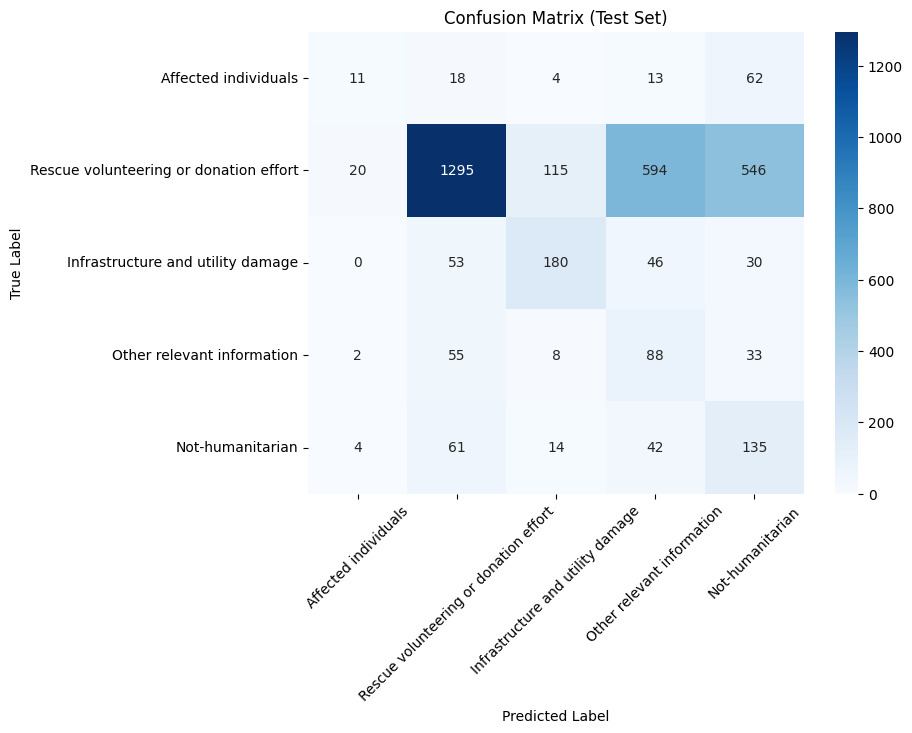

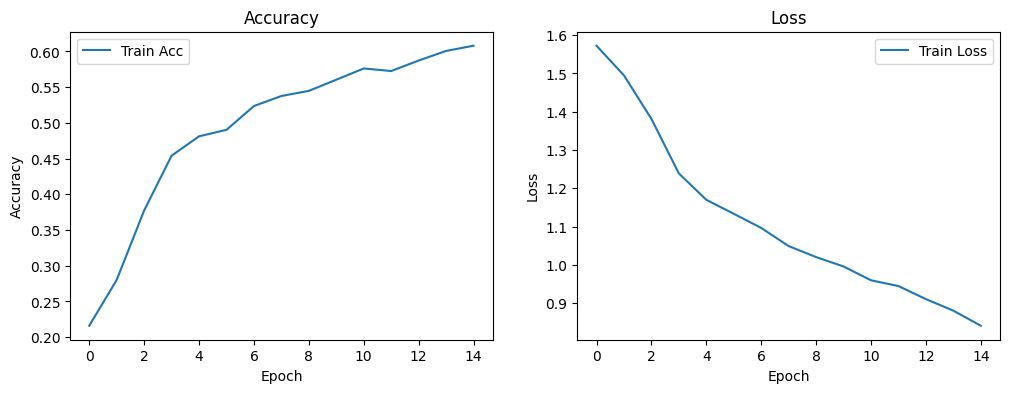

In [10]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.metrics import Metric
from tensorflow.keras import backend as K

# Custom MacroF1Score Metric
class MacroF1Score(Metric):
    def __init__(self, num_classes, name='macro_f1_score', **kwargs):
        super(MacroF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert y_true to one-hot if not already
        y_true = tf.cast(y_true, tf.float32)
        if len(y_true.shape) == 1 or y_true.shape[-1] == 1:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)
        else:
            y_true = tf.cast(y_true, tf.float32)

        # Get predicted class indices
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.one_hot(y_pred, depth=self.num_classes)

        # Compute TP, FP, FN for each class
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

        # Update state
        self.true_positives.assign(self.true_positives + tp)
        self.false_positives.assign(self.false_positives + fp)
        self.false_negatives.assign(self.false_negatives + fn)

    def result(self):
        precision = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_positives)
        recall = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_negatives)
        
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        macro_f1 = tf.reduce_mean(f1)
        return macro_f1

    def reset_states(self):
        self.true_positives.assign(tf.zeros(self.num_classes))
        self.false_positives.assign(tf.zeros(self.num_classes))
        self.false_negatives.assign(tf.zeros(self.num_classes))

    def get_config(self):
        config = super(MacroF1Score, self).get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# GPU Setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("✅ Using GPU")
else:
    print("⚠ Using CPU")

# Data Paths
base_path = "/kaggle/working/output"
os.makedirs(base_path, exist_ok=True)
train_dir = "/kaggle/input/split-data/content/split_data/train"
test_dir = "/kaggle/input/split-data/content/split_data/test"

# Define the mapping for 5-class classification
human_mapping = {
    'California_Wildfires': 2,      # "Infrastructure and utility damage"
    'Hurricane_Harvey': 1,         # "Rescue volunteering or donation effort"
    'mexico_earthquake': 4,        # "Not-humanitarian"
    'iraq_iran_earthquake': 0,     # "Affected individuals"
    'srilanka_floods': 3,          # "Other relevant information"
    'Hurricane_Maria': 1,          # "Rescue volunteering or donation effort"
    'Hurricane_Irma': 1            # "Rescue volunteering or donation effort"
}

# Utility function: Create DataFrame
def create_dataframe(data_dir, mapping):
    filepaths = []
    labels = []

    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory {data_dir} does not exist.")

    for class_name, label in mapping.items():
        folder_path = os.path.join(data_dir, class_name)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist. Skipping...")
            continue

        files = glob.glob(os.path.join(folder_path, '*.jpg')) + \
                glob.glob(os.path.join(folder_path, '*.jpeg')) + \
                glob.glob(os.path.join(folder_path, '*.png'))

        if not files:
            print(f"Warning: No image files found in {folder_path}. Skipping...")
            continue

        print(f"Found {len(files)} files in {folder_path}")
        filepaths.extend(files)
        labels.extend([str(label)] * len(files))

    df = pd.DataFrame({'filename': filepaths, 'class': labels})
    if df.empty:
        raise ValueError(f"No data found in {data_dir}.")
    return df

# Create DataFrames
try:
    train_df = create_dataframe(train_dir, human_mapping)
    test_df = create_dataframe(test_dir, human_mapping)
except Exception as e:
    print(f"Error creating DataFrames: {e}")
    raise

# Data Augmentation for Imbalanced Classes
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    fill_mode='nearest'
)

# Identify and augment minority classes
class_counts = train_df['class'].value_counts()
minority_threshold = class_counts.median() * 0.7
augmentation_factor = 3

for minority_class in class_counts[class_counts < minority_threshold].index:
    minority_class_dir = os.path.join(base_path, f"augmented_class_{minority_class}")
    os.makedirs(minority_class_dir, exist_ok=True)

    augmented_filepaths = []
    augmented_labels = []
    for img_file in train_df[train_df['class'] == minority_class]['filename']:
        img = load_img(img_file)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        save_prefix = "aug_" + os.path.splitext(os.path.basename(img_file))[0]
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=minority_class_dir, save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i >= augmentation_factor:
                break
    new_files = glob.glob(os.path.join(minority_class_dir, '*.jpg'))
    augmented_filepaths.extend(new_files)
    augmented_labels.extend([minority_class] * len(new_files))
    
    augmented_df = pd.DataFrame({'filename': augmented_filepaths, 'class': augmented_labels})
    train_df = pd.concat([train_df, augmented_df], ignore_index=True)
    print(f"Augmentation complete for class {minority_class}! Added {len(augmented_filepaths)} images.")

# Data Generators
IMG_SIZE = (224, 224)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=[0.8, 1.2],
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

try:
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
except Exception as e:
    print(f"Error setting up data generators: {e}")
    raise

# Compute Class Weights
try:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['class']),
        y=train_df['class']
    )
    class_weights = {i: w for i, w in enumerate(class_weights)}
    print("Computed class weights:", class_weights)
except Exception as e:
    print(f"Error computing class weights: {e}")
    raise

# Build VGG16-based model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = True

# Freeze all layers except last 6
for layer in base_model.layers[:-6]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', MacroF1Score(num_classes=5)]
)

# Callbacks
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_ckpt_best = ModelCheckpoint(
    os.path.join(base_path, "best_model.keras"),
    save_best_only=True,
    monitor='accuracy',
    mode='max'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop, model_ckpt_best],
    verbose=1
)

# Save Final Model
final_model_path = os.path.join(base_path, "final_trained_model.keras")
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(os.path.join(base_path, "model_flutter.tflite"), "wb") as f:
    f.write(tflite_model)
print("✅ TFLite model saved")

# Evaluation on Test Set
model = load_model(os.path.join(base_path, "best_model.keras"), custom_objects={'MacroF1Score': MacroF1Score})
y_true_test = test_generator.classes
y_pred_test = model.predict(test_generator)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

cm = confusion_matrix(y_true_test, y_pred_test_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
    "Affected individuals",
    "Rescue volunteering or donation effort",
    "Infrastructure and utility damage",
    "Other relevant information",
    "Not-humanitarian"
], yticklabels=[
    "Affected individuals",
    "Rescue volunteering or donation effort",
    "Infrastructure and utility damage",
    "Other relevant information",
    "Not-humanitarian"
])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig(os.path.join(base_path, 'confusion_matrix.png'))

test_acc = accuracy_score(y_true_test, y_pred_test_classes)
test_prec = precision_score(y_true_test, y_pred_test_classes, average='weighted')
test_rec = recall_score(y_true_test, y_pred_test_classes, average='weighted')
test_f1 = f1_score(y_true_test, y_pred_test_classes, average='weighted')

print("\n✅ Test Set Evaluation:")
print(f"Accuracy: {test_acc:.4f} | Precision: {test_prec:.4f} | Recall: {test_rec:.4f} | F1 Score: {test_f1:.4f}")
print("\n🧾 Classification Report (Test):")
print(classification_report(y_true_test, y_pred_test_classes, target_names=[
    "Affected individuals",
    "Rescue volunteering or donation effort",
    "Infrastructure and utility damage",
    "Other relevant information",
    "Not-humanitarian"
]))

# Visualize Metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(base_path, 'training_metrics.png'))